<a href="https://colab.research.google.com/github/sqb-codes/ATAL_FDP_24/blob/main/GAN_BladderCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

os.environ["KAGGLE_USERNAME"] = "squarebrackets"
os.environ["KAGGLE_KEY"] = "b2ee878c1b5d541bf70ac9ed1a0289e3"

!kaggle datasets download shirtgm/bladder-cancer-classification

Dataset URL: https://www.kaggle.com/datasets/shirtgm/bladder-cancer-classification
License(s): unknown
 99% 162M/164M [00:09<00:00, 24.0MB/s]
100% 164M/164M [00:09<00:00, 17.2MB/s]


In [2]:
!unzip bladder-cancer-classification.zip

Archive:  bladder-cancer-classification.zip
  inflating: Center_1/muscle invasive bladder/0.png  
  inflating: Center_1/muscle invasive bladder/1.png  
  inflating: Center_1/muscle invasive bladder/10.png  
  inflating: Center_1/muscle invasive bladder/100.png  
  inflating: Center_1/muscle invasive bladder/101.png  
  inflating: Center_1/muscle invasive bladder/102.png  
  inflating: Center_1/muscle invasive bladder/103.png  
  inflating: Center_1/muscle invasive bladder/104.png  
  inflating: Center_1/muscle invasive bladder/105.png  
  inflating: Center_1/muscle invasive bladder/106.png  
  inflating: Center_1/muscle invasive bladder/107.png  
  inflating: Center_1/muscle invasive bladder/108.png  
  inflating: Center_1/muscle invasive bladder/109.png  
  inflating: Center_1/muscle invasive bladder/11.png  
  inflating: Center_1/muscle invasive bladder/110.png  
  inflating: Center_1/muscle invasive bladder/111.png  
  inflating: Center_1/muscle invasive bladder/112.png  
  inflatin

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import cv2

In [7]:
img = cv2.imread("Center_1/muscle invasive bladder/1.png")

In [8]:
img.shape

(320, 320, 3)

(-0.5, 319.5, 319.5, -0.5)

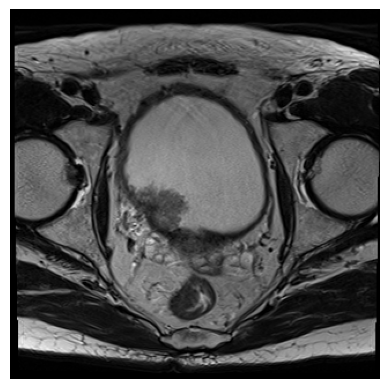

In [10]:
plt.imshow(img)
plt.axis("off")

In [13]:
# Load the dataset
def load_data(dir, image_size=(64,64)):
  dataset = tf.keras.preprocessing.image_dataset_from_directory(
      dir,
      label_mode=None,
      image_size=image_size,
      batch_size=32,
      shuffle=True,
      color_mode="grayscale"
  )
  dataset = dataset.map(lambda x : (x / 255.0))
  return dataset

In [14]:
data = load_data("Center_1")

Found 641 files.


In [15]:
# Build generator model
def build_generator(noise_dim):
  model = tf.keras.Sequential([
      layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(noise_dim,)),
      layers.BatchNormalization(),
      layers.LeakyReLU(),

      # Reshape the output into a 3D tensor (image format)
      layers.Reshape((8, 8, 256)),

      # Upsample - 16x16
      layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding="same", use_bias=False),
      layers.BatchNormalization(),
      layers.LeakyReLU(),

      # Upsample - 32x32
      layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding="same", use_bias=False),
      layers.BatchNormalization(),
      layers.LeakyReLU(),

      # Upsample - 64x64
      layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding="same", use_bias=False, activation="tanh")
  ])
  return model

In [16]:
def build_discriminator():
  model = tf.keras.Sequential([
      # Downsample - 32x32
      layers.Conv2D(64, (5,5), strides=(2,2), padding="same", input_shape=[64,64,1]),
      layers.LeakyReLU(),
      layers.Dropout(0.3),

      # Downsample - 16 x 16
      layers.Conv2D(128, (5,5), strides=(2,2), padding="same"),
      layers.LeakyReLU(),
      layers.Dropout(0.3),

      # Downsample - 8 x 8
      layers.Conv2D(256, (5,5), strides=(2,2), padding="same"),
      layers.LeakyReLU(),
      layers.Dropout(0.3),

      layers.Flatten(),
      layers.Dense(1)
  ])

  return model

In [17]:
noise_dim = 100
generator = build_generator(noise_dim)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
# generator.summary()

In [21]:
fake_img = generator.predict(np.random.normal(size=(1, noise_dim)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [22]:
fake_img.shape

(1, 64, 64, 1)

(-0.5, 63.5, 63.5, -0.5)

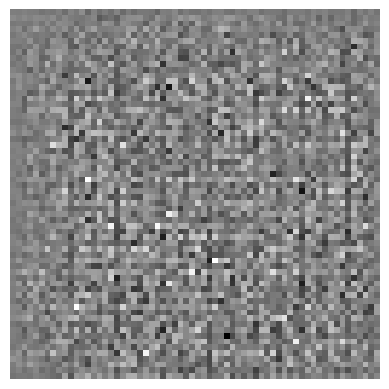

In [23]:
plt.imshow(fake_img[0, :, :, 0], cmap="gray")
plt.axis("off")

In [24]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
def generator_loss(fake_output):
  # loss for classifying fake images as real
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [26]:
def discriminator_loss(real_output, fake_output):
  # loss for classifying real images as real
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  # loss for classifying fake image as fake
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

In [27]:
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()

In [28]:
discriminator = build_discriminator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # generate fake images using generator
    generated_images = generator(noise, training=True)

    # classify real and fake images using discriminator
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    # calculate generator and discriminator loss
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss

In [30]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i, :, :, 0], cmap="gray")
    plt.axis("off")

  plt.savefig(f"image_at_epoch_{epoch:04d}.png")
  plt.show()

def train(dataset, epochs):
  for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      print(f"Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}")

      if(epoch + 1) % 10 == 0:
        generate_and_save_images(generator, epoch + 1, tf.random.normal([16, noise_dim]))

Epoch 1/100
Generator Loss: 0.7033081650733948, Discriminator Loss: 1.3794150352478027
Generator Loss: 0.924401044845581, Discriminator Loss: 1.0260683298110962
Generator Loss: 1.1916862726211548, Discriminator Loss: 0.5609670877456665
Generator Loss: 2.562507390975952, Discriminator Loss: 0.15098541975021362
Generator Loss: 5.392058372497559, Discriminator Loss: 0.02813093364238739
Generator Loss: 2.2958600521087646, Discriminator Loss: 0.1356666386127472
Generator Loss: 10.99875545501709, Discriminator Loss: 0.6910533308982849
Generator Loss: 1.0735127925872803, Discriminator Loss: 0.510982871055603
Generator Loss: 10.43450927734375, Discriminator Loss: 0.0009743325645104051
Generator Loss: 14.66401195526123, Discriminator Loss: 0.0010117893107235432
Generator Loss: 17.948535919189453, Discriminator Loss: 0.0006348254974000156
Generator Loss: 18.049516677856445, Discriminator Loss: 0.0009263274259865284
Generator Loss: 19.359844207763672, Discriminator Loss: 0.0007188415038399398
Gen

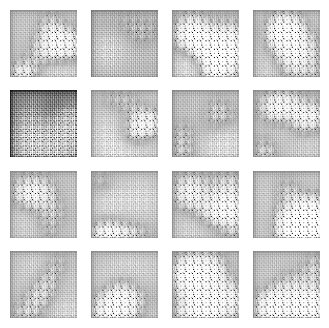

Generator Loss: 8.007645606994629, Discriminator Loss: 0.6728747487068176


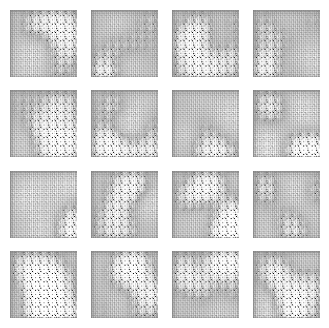

Generator Loss: 10.641697883605957, Discriminator Loss: 0.19013191759586334


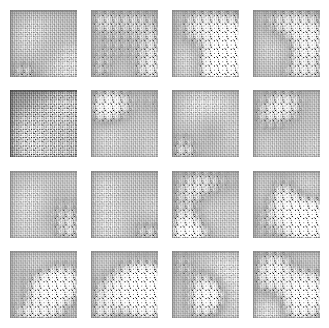

Generator Loss: 16.687053680419922, Discriminator Loss: 0.03793762996792793


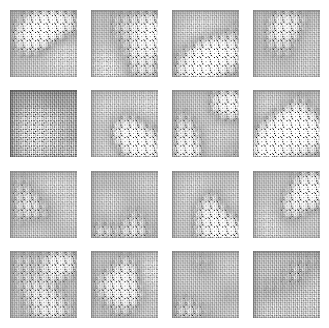

Generator Loss: 22.346696853637695, Discriminator Loss: 0.1447560042142868


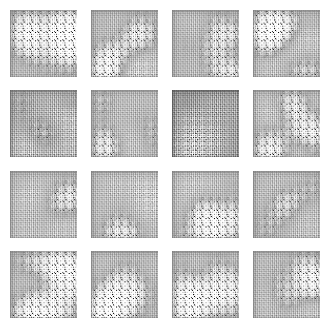

Generator Loss: 27.528833389282227, Discriminator Loss: 0.13127174973487854


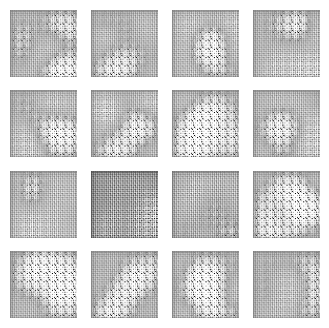

Generator Loss: 26.110830307006836, Discriminator Loss: 0.2901877462863922


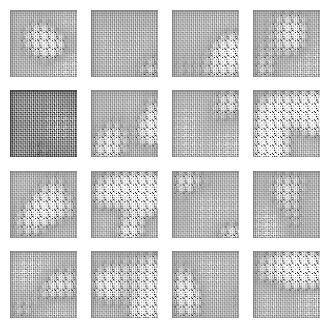

Generator Loss: 24.78563690185547, Discriminator Loss: 0.2895283102989197


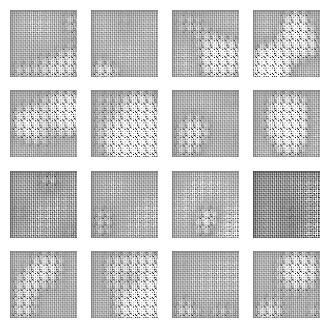

Generator Loss: 20.480335235595703, Discriminator Loss: 0.008651377633213997


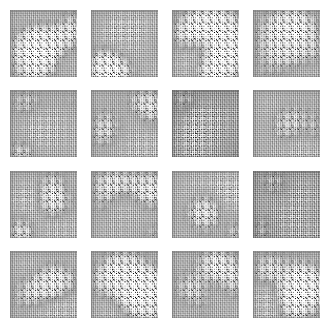

Generator Loss: 19.329055786132812, Discriminator Loss: 0.006122114602476358


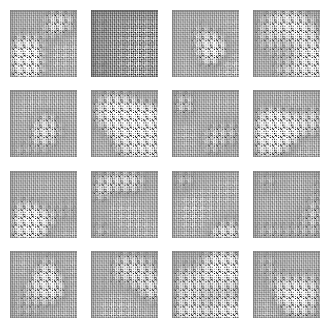

Generator Loss: 18.543479919433594, Discriminator Loss: 0.0006671037408523262


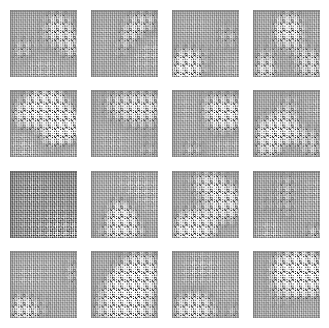

Generator Loss: 17.996313095092773, Discriminator Loss: 0.0009104401688091457


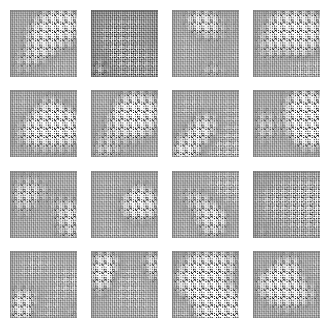

Generator Loss: 21.584857940673828, Discriminator Loss: 0.0003049497026950121


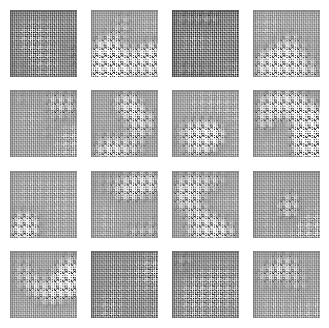

Generator Loss: 16.926298141479492, Discriminator Loss: 0.000300360145047307


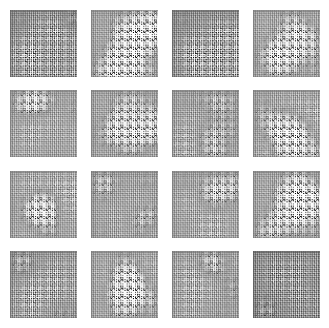

Generator Loss: 16.517568588256836, Discriminator Loss: 0.00038792670238763094


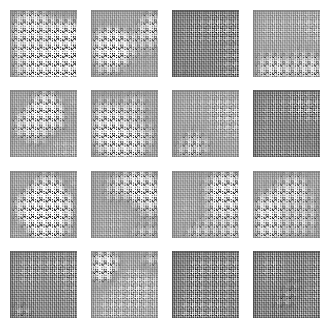

Generator Loss: 13.771615982055664, Discriminator Loss: 0.00035172098432667553


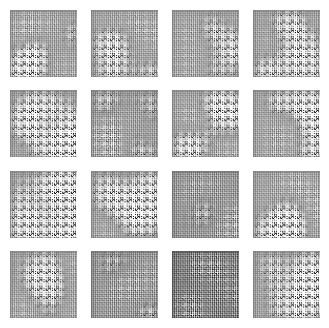

Generator Loss: 11.490283966064453, Discriminator Loss: 0.045717060565948486


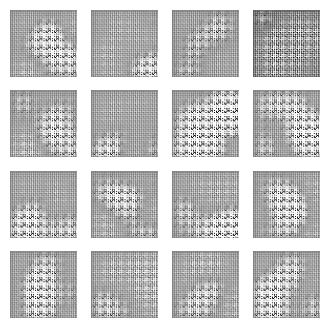

Generator Loss: 10.546184539794922, Discriminator Loss: 0.1739906519651413


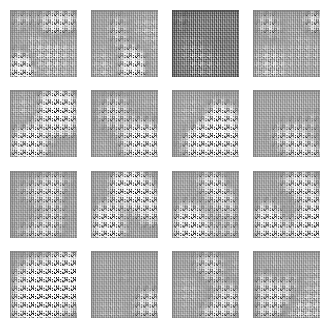

Generator Loss: 12.999865531921387, Discriminator Loss: 0.10418687015771866


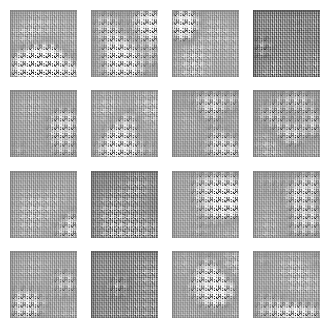

Generator Loss: 17.366680145263672, Discriminator Loss: 0.013191374950110912


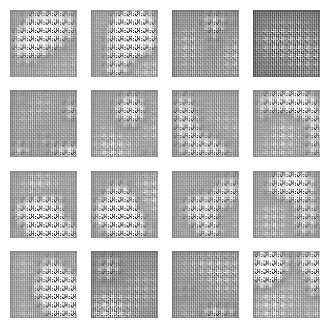

Generator Loss: 21.072689056396484, Discriminator Loss: 0.0011491102632135153


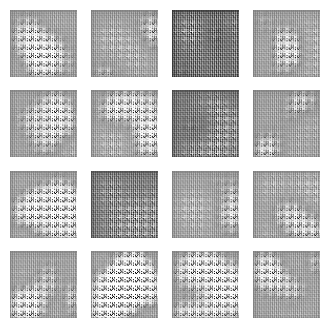

Epoch 11/100
Generator Loss: 18.846813201904297, Discriminator Loss: 0.0017441643867641687
Generator Loss: 20.54803466796875, Discriminator Loss: 0.0505252368748188
Generator Loss: 22.23051643371582, Discriminator Loss: 0.0013576303608715534
Generator Loss: 25.703250885009766, Discriminator Loss: 0.0017388596897944808
Generator Loss: 24.347049713134766, Discriminator Loss: 0.5901744961738586
Generator Loss: 26.801036834716797, Discriminator Loss: 0.00922967866063118
Generator Loss: 28.6768798828125, Discriminator Loss: 0.008530950173735619
Generator Loss: 22.685104370117188, Discriminator Loss: 0.767742931842804
Generator Loss: 36.22956848144531, Discriminator Loss: 0.0447845421731472
Generator Loss: 39.05625915527344, Discriminator Loss: 0.3212819993495941
Generator Loss: 26.694194793701172, Discriminator Loss: 0.45101332664489746
Generator Loss: 24.814178466796875, Discriminator Loss: 0.7967010140419006
Generator Loss: 20.659912109375, Discriminator Loss: 0.41194817423820496
Generato

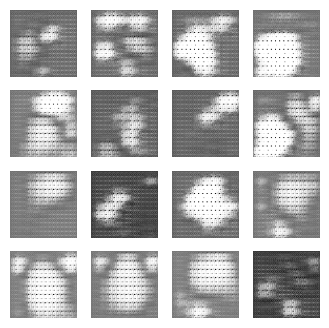

Generator Loss: 41.47429656982422, Discriminator Loss: 0.00023614596284460276


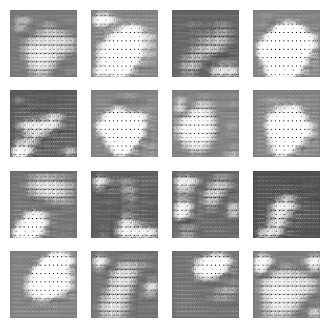

Generator Loss: 42.042572021484375, Discriminator Loss: 6.074275734135881e-05


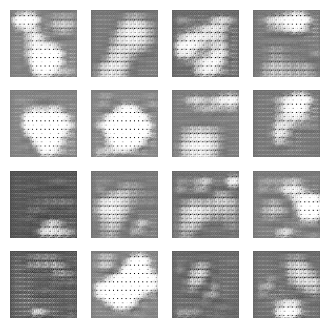

Generator Loss: 35.63579559326172, Discriminator Loss: 6.4336862124037e-05


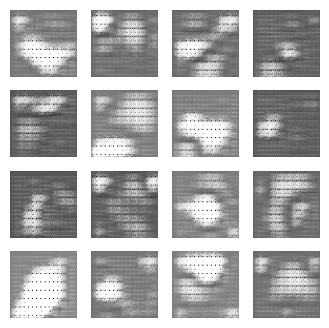

Generator Loss: 26.798166275024414, Discriminator Loss: 0.00019581599917728454


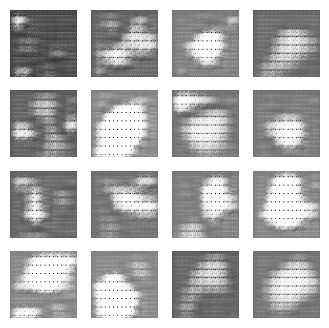

Generator Loss: 12.785581588745117, Discriminator Loss: 0.546079695224762


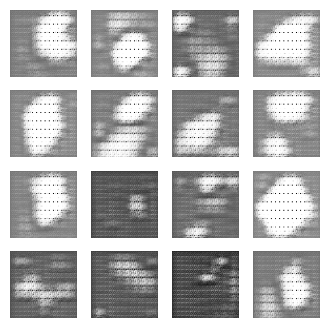

Generator Loss: 10.150718688964844, Discriminator Loss: 0.47515296936035156


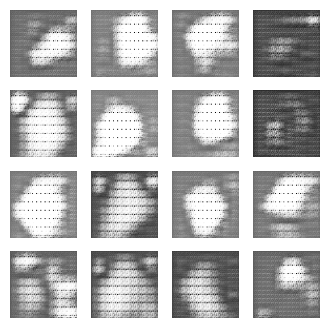

Generator Loss: 17.61855125427246, Discriminator Loss: 0.5705339312553406


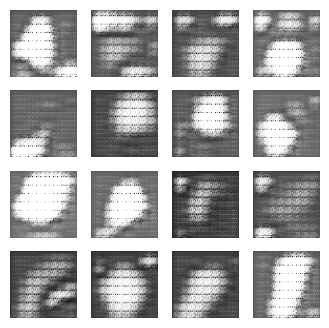

Generator Loss: 24.70535659790039, Discriminator Loss: 0.052851926535367966


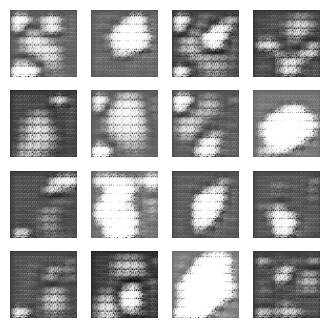

Generator Loss: 25.6373233795166, Discriminator Loss: 0.2889907658100128


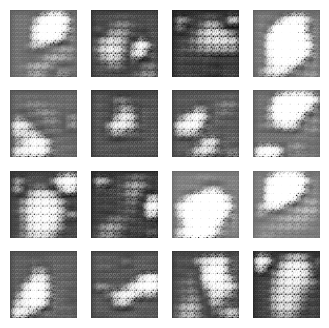

Generator Loss: 27.214750289916992, Discriminator Loss: 1.3723514080047607


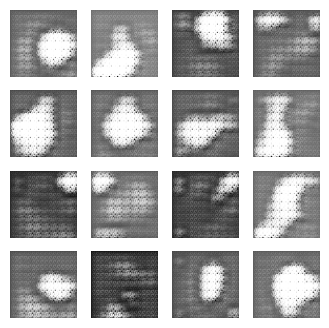

Generator Loss: 11.83099365234375, Discriminator Loss: 1.1718018054962158


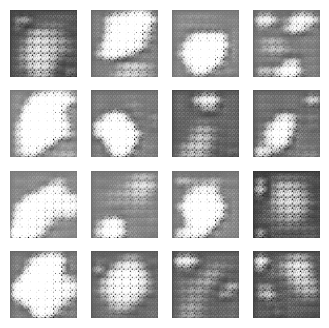

Generator Loss: 4.311188697814941, Discriminator Loss: 2.539094924926758


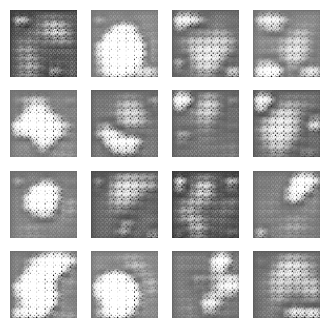

Generator Loss: 9.465311050415039, Discriminator Loss: 1.456479787826538


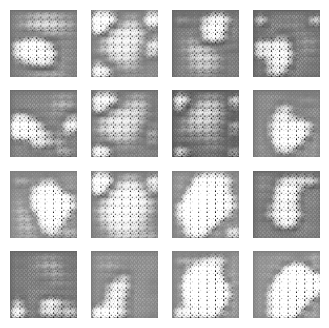

Generator Loss: 9.914273262023926, Discriminator Loss: 2.5665245056152344


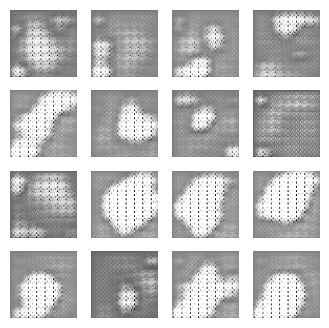

Generator Loss: 5.488152503967285, Discriminator Loss: 0.8200501203536987


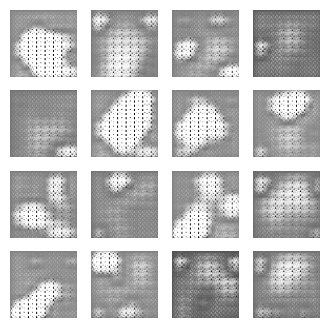

Generator Loss: 5.695980548858643, Discriminator Loss: 0.47524595260620117


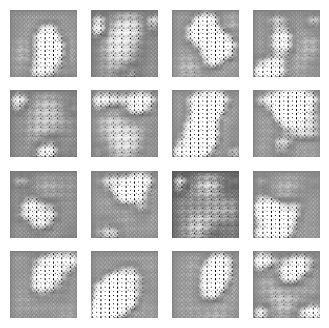

Generator Loss: 8.940145492553711, Discriminator Loss: 0.38702112436294556


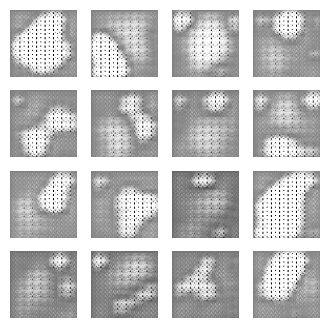

Generator Loss: 18.16004180908203, Discriminator Loss: 0.3416498899459839


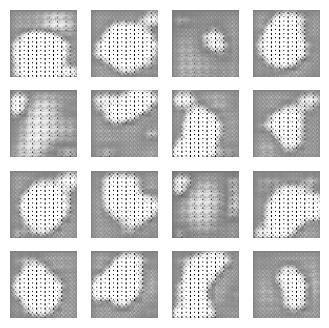

Generator Loss: 15.219183921813965, Discriminator Loss: 0.4730290472507477


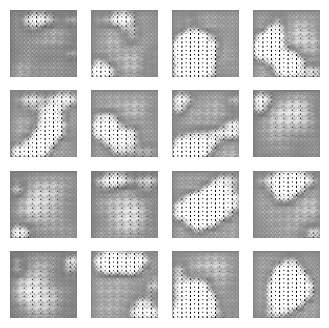

Generator Loss: 19.853302001953125, Discriminator Loss: 0.018706142902374268


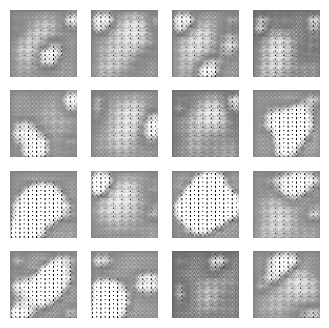

Epoch 21/100
Generator Loss: 18.364805221557617, Discriminator Loss: 0.17907986044883728
Generator Loss: 22.738140106201172, Discriminator Loss: 0.06524144858121872
Generator Loss: 21.516685485839844, Discriminator Loss: 0.09274500608444214
Generator Loss: 20.692420959472656, Discriminator Loss: 0.2820535898208618
Generator Loss: 18.928274154663086, Discriminator Loss: 0.3095220923423767
Generator Loss: 21.871501922607422, Discriminator Loss: 0.6851414442062378
Generator Loss: 21.26803207397461, Discriminator Loss: 0.34539899230003357
Generator Loss: 23.47735595703125, Discriminator Loss: 0.5443516969680786
Generator Loss: 26.311830520629883, Discriminator Loss: 0.3249322772026062
Generator Loss: 26.72936248779297, Discriminator Loss: 0.7299574017524719
Generator Loss: 23.53388214111328, Discriminator Loss: 0.4459150433540344
Generator Loss: 23.657657623291016, Discriminator Loss: 0.27728521823883057
Generator Loss: 18.6931095123291, Discriminator Loss: 0.3186546564102173
Generator Los

KeyboardInterrupt: 

In [31]:
EPOCHS = 100
BATCH_SIZE = 16
train(data, EPOCHS)